In [19]:
from math import radians, sin, cos, asin, sqrt

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,15)

In [3]:
topology_data = pd.read_csv('../data/traceset/clustered_topology.csv')

In [40]:
node_list = [i*10 for i in range(10)]
node_list.append(99300)
topology_data_cut = topology_data[topology_data["fog"].isin(node_list)]

In [32]:
topology_data_cut

,bs,lat,lon,type,fog
0,0,13.289695,111.219577,fog,0
1,10,13.145352,111.066682,fog,10
2,20,13.123322,111.100477,fog,20
3,30,13.190210,111.163722,fog,30
4,40,13.157255,111.028934,fog,40
5,50,13.055363,111.048115,fog,50
6,60,13.037477,111.176133,fog,60
7,70,13.186032,111.087748,fog,70
8,80,13.209968,111.012841,fog,80
9,90,13.193633,111.241484,fog,90


In [52]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def create_dist_df(df):
    df.reset_index(drop=True, inplace=True)

    dist_dict = {"from": [], "to": [], "distance": []}
    dist_matrix = np.zeros([len(df), len(df)])
    
    fog_list = df[df["type"] == "fog"]["bs"]
    
    for fog_id in fog_list:
        connected_nodes = df[(df["fog"] == fog_id) | (df["type"] == "fog") | (df["type"] == "cloud")]

        for i in connected_nodes.itertuples():
            idx_i, bs_from, lat_i, lon_i, type_i, fog_i = i[0], i[1], i[2], i[3], i[4], i[5]
            
            if type_i == "rrh" or type_i == "cloud" or fog_i != fog_id:
                continue
                
            for j in connected_nodes.itertuples():
                idx_j, bs_to, lat_j, lon_j, type_j = j[0], j[1], j[2], j[3], j[4]
                
                dist_dict["from"].append(bs_from)
                dist_dict["to"].append(bs_to)
                dist_dict["distance"].append(haversine(lon_i, lat_i, lon_j, lat_j))
    
    return pd.DataFrame.from_dict(dist_dict)

In [53]:
dist_matrix = create_dist_df(topology_data_cut)

In [54]:
dist_matrix[(dist_matrix['to'] == 99300) | (dist_matrix['from'] == 99300)]

,from,to,distance
13,0,99300,7.432184
27,10,99300,29.868444
41,20,99300,29.764564
55,30,99300,19.970839
69,40,99300,31.691304
83,50,99300,39.173490
97,60,99300,35.790603
111,70,99300,24.949425
125,80,99300,29.441461
139,90,99300,17.713228


In [55]:
sensor_ids = topology_data_cut['bs'].values
normalized_k = 0.1
num_sensors = len(sensor_ids)
dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
dist_mx[:] = np.inf
# Builds sensor id to index map.
sensor_id_to_ind = {}

for i, sensor_id in enumerate(sensor_ids):
    sensor_id_to_ind[sensor_id] = i

# Fills cells in the matrix with distances.
for row in dist_matrix.values:
    if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
        continue
    dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = row[2]

# Calculates the standard deviation as theta.
distances = dist_mx[~np.isinf(dist_mx)].flatten()
std = distances.std()
adj_mx = np.exp(-np.square(dist_mx / std))
# Make the adjacent matrix symmetric by taking the max.
# adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

# Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
adj_mx[adj_mx < normalized_k] = 0

{0: Text(-0.5873451302056214, -0.5716491831777571, '0'),
 1: Text(0.0853055534266116, -0.0031983855287934554, '10'),
 2: Text(0.22665446885034787, 0.18525908259378981, '20'),
 3: Text(-0.2441994461562076, 0.0033250665028356934, '30'),
 4: Text(-0.04837812862852609, 0.114005340894639, '40'),
 5: Text(0.4047621889937047, -0.08589482597186533, '50'),
 6: Text(0.8171004483826575, 0.26061308011711, '60'),
 7: Text(0.1153643363046934, 0.11603972085506327, '70'),
 8: Text(-0.007661590106525694, 0.36855089186513634, '80'),
 9: Text(-0.6498604615780744, -0.2180685365170811, '90'),
 10: Text(-0.5265575211233241, -0.7267018621417144, '1'),
 11: Text(-0.7529424688262245, -0.6602392620887508, '2'),
 12: Text(-0.6639866136677716, -0.7214084466857386, '3'),
 13: Text(0.0013422634912179116, -0.16354130545349443, '11'),
 14: Text(0.16983536694050036, -0.17228453870215507, '12'),
 15: Text(0.08220203454130533, -0.2090811875954343, '13'),
 16: Text(0.35927991731818987, 0.3499800826097094, '21'),
 17: Tex

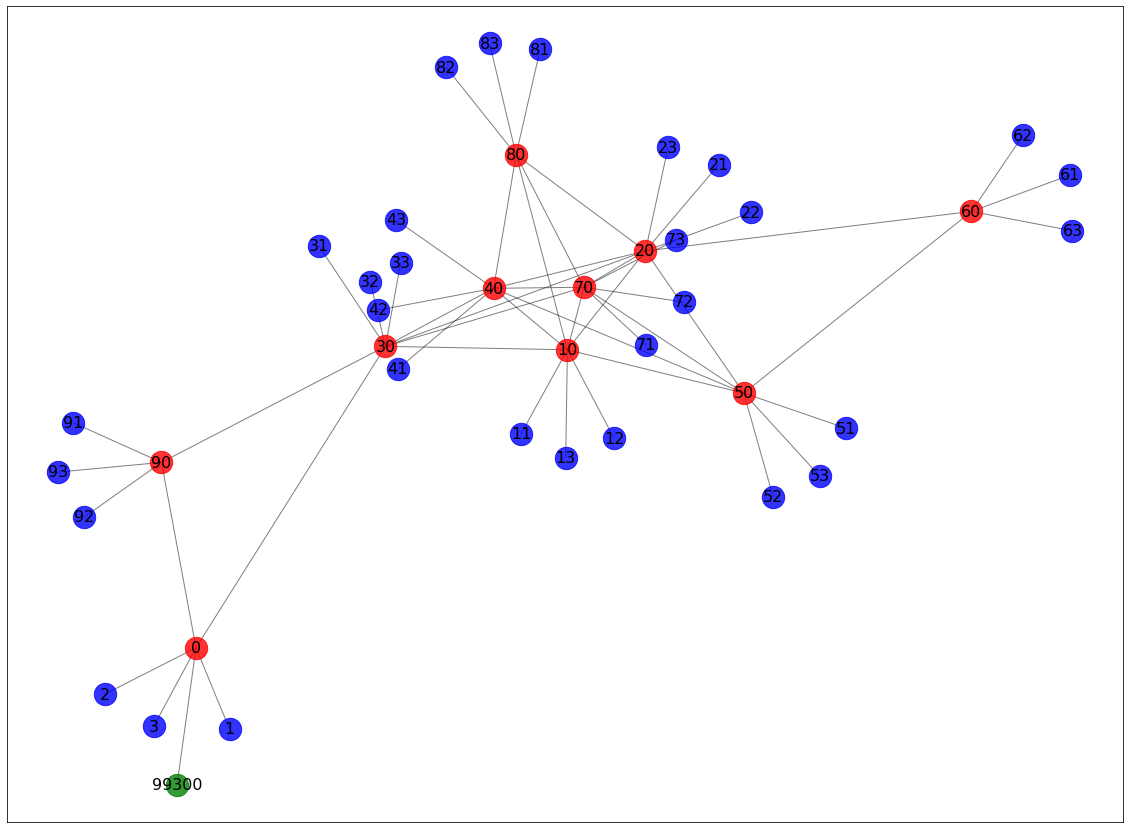

In [56]:
G = nx.from_numpy_matrix(adj_mx)
pos=nx.spring_layout(G) 
G.edges(data=True)

nx.draw_networkx_nodes(G,pos,
                       nodelist=topology_data_cut[topology_data_cut["type"] == "cloud"]["bs"].index,
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=topology_data_cut[topology_data_cut["type"] == "fog"]["bs"].index,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=topology_data_cut[topology_data_cut["type"] == "rrh"]["bs"].index,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)


labels = {}
for idx, val in enumerate(topology_data_cut["bs"].values):
    labels[idx] = val


nx.draw_networkx_labels(G,pos,labels,font_size=16)

In [57]:
G.edges

EdgeView([(0, 0), (0, 3), (0, 9), (0, 10), (0, 11), (0, 12), (0, 40), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (1, 8), (1, 13), (1, 14), (1, 15), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 16), (2, 17), (2, 18), (3, 3), (3, 4), (3, 7), (3, 9), (3, 19), (3, 20), (3, 21), (4, 4), (4, 5), (4, 7), (4, 8), (4, 22), (4, 23), (4, 24), (5, 5), (5, 6), (5, 7), (5, 25), (5, 26), (5, 27), (6, 6), (6, 28), (6, 29), (6, 30), (7, 7), (7, 8), (7, 31), (7, 32), (7, 33), (8, 8), (8, 34), (8, 35), (8, 36), (9, 9), (9, 37), (9, 38), (9, 39)])